In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
openc

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import os
import time
import pickle

# For Word2Vec
from gensim.models import Word2Vec

# For data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# For Keras model building
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout # Import Bidirectional and LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/MyDrive/Depression detection dataset/BSMDD_main.xlsx'
df = pd.read_excel(file_path)

# Drop any rows where the text is missing and reset index
df.dropna(subset=['text_banglish'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Libraries imported, Drive mounted, and dataset loaded successfully.")
df.info()

Mounted at /content/drive
Libraries imported, Drive mounted, and dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21910 entries, 0 to 21909
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_bengali   21910 non-null  object
 1   text_banglish  21910 non-null  object
 2   label          21910 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 513.6+ KB


In [ ]:
# --- 1. Define the text preprocessing function ---
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase and ensure it's a string
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation, numbers, etc.
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

# --- 2. Apply the function to create a 'cleaned_text' column ---
df['cleaned_text'] = df['text_banglish'].apply(preprocess_text)

# --- 3. Tokenize the cleaned text into lists of words ---
# This is required for the Gensim Word2Vec model in the next step
df['tokenized_text'] = df['cleaned_text'].apply(lambda x: x.split())

# --- 4. Safeguard: Remove any rows that became empty after cleaning ---
original_rows = len(df)
df = df[df['cleaned_text'] != ''].reset_index(drop=True)
if original_rows > len(df):
    print(f"Removed {original_rows - len(df)} rows that were empty after preprocessing.")

# --- 5. Display the result to verify ---
print("DataFrame after preprocessing and tokenization:")
print(df[['text_banglish', 'cleaned_text', 'tokenized_text', 'label']].head())

Removed 2 rows that were empty after preprocessing.
DataFrame after preprocessing and tokenization:
                                       text_banglish  \
0  manasika sharirikabhabe asustha klanta puro ji...   
1  daya sathe thakuna atyanta dirgha apanake pada...   
2  janatama sathe bhula loka kharapa jibana katiy...   
3  anetibha imreji spikarera anusarana biraktikar...   
4  anetibha imreji spikarera anusarana biraktikar...   

                                        cleaned_text  \
0  manasika sharirikabhabe asustha klanta puro ji...   
1  daya sathe thakuna atyanta dirgha apanake pada...   
2  janatama sathe bhula loka kharapa jibana katiy...   
3  anetibha imreji spikarera anusarana biraktikar...   
4  anetibha imreji spikarera anusarana biraktikar...   

                                      tokenized_text  label  
0  [manasika, sharirikabhabe, asustha, klanta, pu...      1  
1  [daya, sathe, thakuna, atyanta, dirgha, apanak...      1  
2  [janatama, sathe, bhula, loka, kharap

In [ ]:
# Isolate the tokenized sentences for training
sentences = df['tokenized_text'].tolist()

# --- Word2Vec Model Training ---
# Define the model parameters
embedding_dim = 100  # Dimensionality of the word vectors
window_size = 5      # Context window size
min_word_count = 1   # Minimum word count to be included

# sg=1 trains the Skip-Gram model, which often works well.
print("Training Word2Vec model... (This might take a minute or two)")
w2v_model = Word2Vec(sentences=sentences,
                     vector_size=embedding_dim,
                     window=window_size,
                     min_count=min_word_count,
                     workers=4, # Use 4 CPU cores for training
                     sg=1)

print("Word2Vec model trained successfully.")

# --- Sanity Check ---
# Check the vocabulary size
vocab_size = len(w2v_model.wv.index_to_key)
print(f"\nVocabulary size: {vocab_size}")

# Test the model by finding the most similar words to a sample word.
try:
    sample_word = 'ami'
    similar_words = w2v_model.wv.most_similar(sample_word)
    print(f"\nWords most similar to '{sample_word}':")
    print(similar_words)
except KeyError:
    print(f"\nCould not perform similarity check. The word '{sample_word}' was not in the vocabulary.")

Training Word2Vec model... (This might take a minute or two)
Word2Vec model trained successfully.

Vocabulary size: 56826

Words most similar to 'ami':
[('anugamidera', 0.9482709765434265), ('prashasakera', 0.9432940483093262), ('byaktikeo', 0.9390219449996948), ('mistike', 0.9364268183708191), ('nambarao', 0.9342079162597656), ('grupatike', 0.9316320419311523), ('bhayankarake', 0.931441605091095), ('dyaba', 0.9311736822128296), ('intaraayakashanera', 0.9308089017868042), ('ranadauna', 0.9304046034812927)]


In [ ]:
# --- 1. Use Keras Tokenizer to convert texts to integer sequences ---
texts = df['cleaned_text'].tolist()
labels = df['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
# The vocab size for the Embedding layer is the number of unique words + 1 (for the 0 padding token)
keras_vocab_size = len(word_index) + 1
print(f"Vocabulary size for Keras Tokenizer: {keras_vocab_size}")


# --- 2. Pad sequences to a uniform length ---
lengths = [len(s) for s in sequences]
maxlen = int(np.percentile(lengths, 95))
print(f"Padding sequences to a max length of: {maxlen}")

X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = labels


# --- 3. Create the embedding matrix from our custom Word2Vec model ---
# This matrix will be used as the initial weights for the Keras Embedding layer.
embedding_matrix = np.zeros((keras_vocab_size, embedding_dim)) # embedding_dim is 100

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = embedding_vector

print(f"Shape of the embedding matrix: {embedding_matrix.shape}")


# --- 4. Split data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y) # stratify ensures similar class distribution

print(f"\nTraining data shape (X_train): {X_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")

Vocabulary size for Keras Tokenizer: 56827
Padding sequences to a max length of: 192
Shape of the embedding matrix: (56827, 100)

Training data shape (X_train): (17526, 192)
Testing data shape (X_test): (4382, 192)


In [ ]:
# --- 1. Build the BiLSTM Model ---

model = Sequential()

# 1. Embedding Layer
# We load our custom Word2Vec-based embedding matrix.
model.add(Embedding(input_dim=keras_vocab_size,
                    output_dim=embedding_dim, # This is 100 for our Word2Vec model
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))

# 2. Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(units=64)))

# 3. Dropout for regularization
model.add(Dropout(0.3))

# 4. A standard Dense layer
model.add(Dense(32, activation='relu'))

# 5. Final Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))


# --- 2. Compile the Model ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# --- 3. Print Model Summary ---
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,682,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,682,700 (21.68 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,682,700 (21.68 MB)

In [ ]:
# --- Train the Model ---

print("Starting BiLSTM model training with Word2Vec embeddings...")

# Use EarlyStopping to prevent overfitting and save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define number of epochs and batch size
epochs = 20
batch_size = 32

# Start the timer
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Stop the timer
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"\nTraining finished in {training_time:.2f} seconds (approx {training_time/60:.1f} minutes).")

Starting BiLSTM model training with Word2Vec embeddings...
Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 111s 184ms/step - accuracy: 0.7825 - loss: 0.4737 - precision: 0.7565 - recall: 0.8344 - val_accuracy: 0.8129 - val_loss: 0.4579 - val_precision: 0.7577 - val_recall: 0.9202
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 100s 182ms/step - accuracy: 0.8490 - loss: 0.3794 - precision: 0.8348 - recall: 0.8720 - val_accuracy: 0.8667 - val_loss: 0.3217 - val_precision: 0.8605 - val_recall: 0.8755
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 116s 211ms/step - accuracy: 0.8719 - loss: 0.3177 - precision: 0.8544 - recall: 0.8980 - val_accuracy: 0.8786 - val_loss: 0.2952 - val_precision: 0.8786 - val_recall: 0.8786
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 128s 185ms/step - accuracy: 0.8891 - loss: 0.2786 - precision: 0.8800 - recall: 0.9024 - val_accuracy: 0.8857 - val_loss: 0.2744 - val_precision: 0.8351 - val_recall: 0.9612
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 101s 185ms/step - accuracy: 0.8960 - loss: 0.

--- Final Performance Evaluation (BiLSTM with Word2Vec) ---
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step

Overall Test Metrics:
Accuracy:  0.9108
F1 Score:  0.9105
ROC-AUC Score: 0.9700

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.91      0.91      0.91      2190
    Depressed (1)       0.91      0.91      0.91      2192

         accuracy                           0.91      4382
        macro avg       0.91      0.91      0.91      4382
     weighted avg       0.91      0.91      0.91      4382


Confusion Matrix:


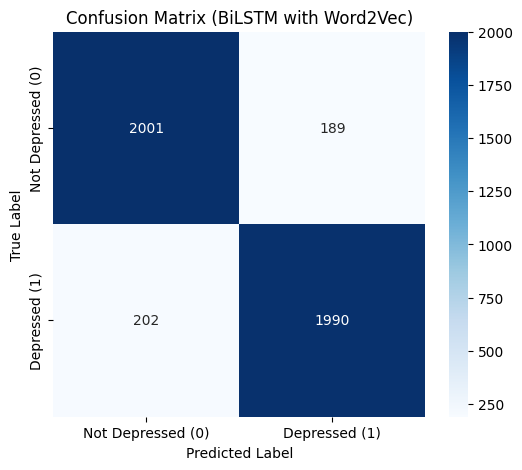



--- Time Complexity ---
Total Training Time: 1570.11 seconds (approx. 26.2 minutes)
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step
Total Inference Time for 4382 samples: 7.6237 seconds
Average Inference Time per Sample: 1.7398 milliseconds


--- Space Complexity ---
Total Model Parameters: 5,771,341
Model Size on Disk: 22.74 MB


In [ ]:
# --- 1. Performance Evaluation on Test Set ---
print("--- Final Performance Evaluation (BiLSTM with Word2Vec) ---")

# Get model's prediction probabilities on the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class labels (0 or 1) using a 0.5 threshold
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate and print the final metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs) # Use probabilities for ROC-AUC

print(f"\nOverall Test Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}\n")

# Display a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Depressed (0)', 'Depressed (1)']))


# --- 2. Display the Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Depressed (0)', 'Depressed (1)'],
            yticklabels=['Not Depressed (0)', 'Depressed (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BiLSTM with Word2Vec)')
plt.show()
print("\n" + "="*50 + "\n")


# --- 3. Practical Time Complexity Analysis ---
print("--- Time Complexity ---")
print(f"Total Training Time: {training_time:.2f} seconds (approx. {training_time/60:.1f} minutes)")

# Measure Inference Time
inference_start_time = time.time()
_ = model.predict(X_test)
inference_end_time = time.time()
total_inference_time = inference_end_time - inference_start_time
avg_inference_time_per_sample = total_inference_time / len(X_test)

print(f"Total Inference Time for {len(X_test)} samples: {total_inference_time:.4f} seconds")
print(f"Average Inference Time per Sample: {avg_inference_time_per_sample * 1000:.4f} milliseconds\n")
print("="*50 + "\n")


# --- 4. Practical Space Complexity Analysis ---
print("--- Space Complexity ---")
total_params = model.count_params()
print(f"Total Model Parameters: {total_params:,}")

# Save the model with a unique name
model_filename = "depression_detection_bilstm_word2vec.keras"
model.save(model_filename)
model_size_bytes = os.path.getsize(model_filename)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Model Size on Disk: {model_size_mb:.2f} MB")

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 192, 100)       │     5,682,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,948,625 (22.69 MB)

 Trainable params: 88,641 (346.25 KB)

 Non-trainable params: 5,682,700 (21.68 MB)

 Optimizer params: 177,284 (692.52 KB)

In [ ]:
import os
import pickle

# --- 1. Save all model components to the Colab environment ---

# a) The custom Word2Vec model
w2v_model_filename = "word2vec_bilstm.model"
w2v_model.save(w2v_model_filename)
print(f"Word2Vec model saved to '{w2v_model_filename}'")

# b) The Keras Tokenizer object
tokenizer_filename = 'tokenizer_bilstm_word2vec.pickle'
with open(tokenizer_filename, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Keras Tokenizer saved to '{tokenizer_filename}'")


# --- 2. Copy all artifacts to your Google Drive ---
# Define the destination folder in your Google Drive
destination_folder = '/content/drive/MyDrive/Depression detection dataset/saved_models/BiLSTM_Word2Vec/'

# Create the folder if it doesn't already exist
os.makedirs(destination_folder, exist_ok=True)

# List of all the files we want to save from this experiment
files_to_copy = [
    'depression_detection_bilstm_word2vec.keras', # Saved in the evaluation step
    'word2vec_bilstm.model',                      # Just saved now
    'tokenizer_bilstm_word2vec.pickle'            # Just saved now
]

# Loop through the files and copy them to your Drive
for filename in files_to_copy:
  source_path = f'./{filename}'
  destination_path = os.path.join(destination_folder, filename)
  if os.path.exists(source_path):
    !cp "{source_path}" "{destination_path}"
    print(f"Successfully copied '{filename}' to your Google Drive.")
  else:
    print(f"Warning: '{filename}' not found. Please ensure the previous cells were run.")

print(f"\nYour BiLSTM with Word2Vec model files are now safely stored in your Google Drive!")

Word2Vec model saved to 'word2vec_bilstm.model'
Keras Tokenizer saved to 'tokenizer_bilstm_word2vec.pickle'
Successfully copied 'depression_detection_bilstm_word2vec.keras' to your Google Drive.
Successfully copied 'word2vec_bilstm.model' to your Google Drive.
Successfully copied 'tokenizer_bilstm_word2vec.pickle' to your Google Drive.

Your BiLSTM with Word2Vec model files are now safely stored in your Google Drive!
